In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from datetime import datetime
import seaborn as sns
from tqdm import tqdm
import math

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, neighbors

# Remove the import of np_utils

print("Setup Complete")


Setup Complete


In [3]:
#df = pd.read_csv("../input/run-or-walk/dataset.csv", index_col='date', parse_dates=True)
df = pd.read_csv("dataset.csv")

df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [4]:
# Summary Statistics 
df.describe()

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000
mean,0.522170,0.500801,-0.074811,-0.562585,-0.313956,0.004160,0.037203,0.022327
std,0.499511,0.500002,1.009299,0.658458,0.486815,1.253423,1.198725,1.914423
min,0.000000,0.000000,-5.350500,-3.299000,-3.753800,-4.430600,-7.464700,-9.480000
25%,0.000000,0.000000,-0.381800,-1.033500,-0.376000,-0.920700,-0.644825,-1.345125
50%,1.000000,1.000000,-0.059500,-0.759100,-0.221000,0.018700,0.039300,0.006900
75%,1.000000,1.000000,0.355500,-0.241775,-0.085900,0.888800,0.733700,1.398200
max,1.000000,1.000000,5.603300,2.668000,1.640300,4.874200,8.498000,11.266200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


In [6]:
df.columns

Index(['date', 'time', 'username', 'wrist', 'activity', 'acceleration_x',
       'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'],
      dtype='object')

In [7]:
df.dtypes

date               object
time               object
username           object
wrist               int64
activity            int64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
dtype: object

In [8]:
df.isna().any()

date              False
time              False
username          False
wrist             False
activity          False
acceleration_x    False
acceleration_y    False
acceleration_z    False
gyro_x            False
gyro_y            False
gyro_z            False
dtype: bool

In [9]:
null_data = df[df.isnull().any(axis=1)]
print(len(null_data))

0


In [10]:
df['activity'].unique()

array([0, 1], dtype=int64)

In [11]:
# Check for missing values
df.isnull().sum()

date              0
time              0
username          0
wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

# EDA ANALYSIS

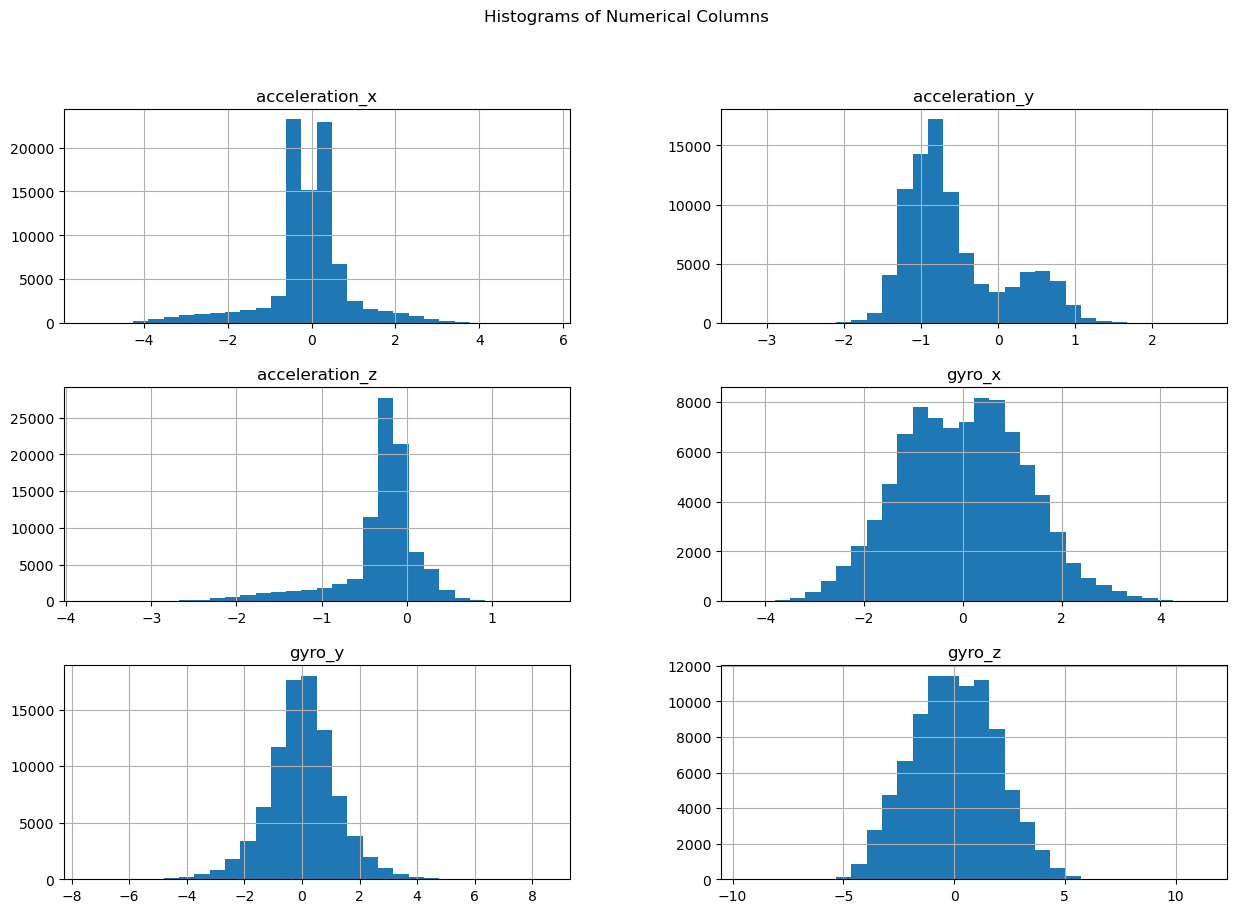

In [12]:
import seaborn as sns

# List of numerical columns
numerical_columns = ['date', 'time', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x','gyro_y','gyro_z']

# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(15, 10), bins=30)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

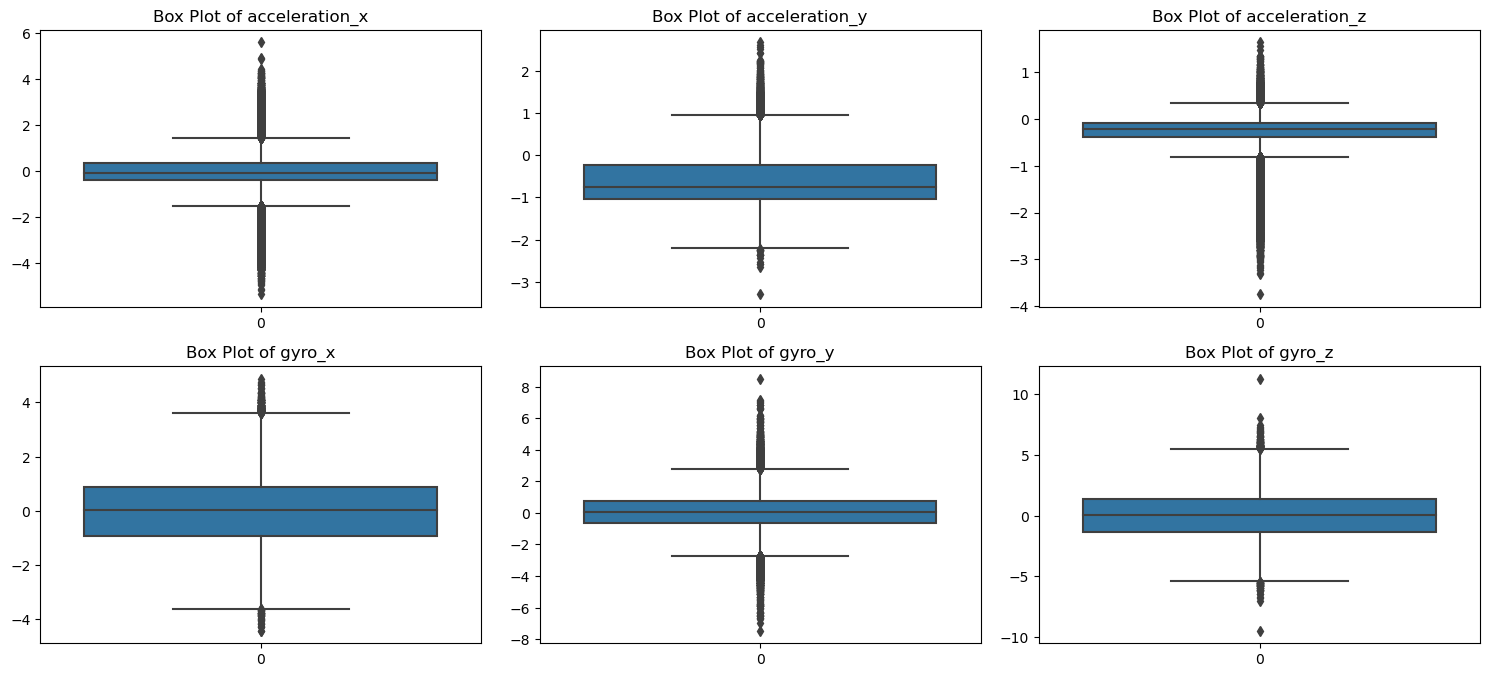

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns (excluding non-numeric ones)
numerical_columns = df.select_dtypes(include=['float']).columns

# Box plots for numerical columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


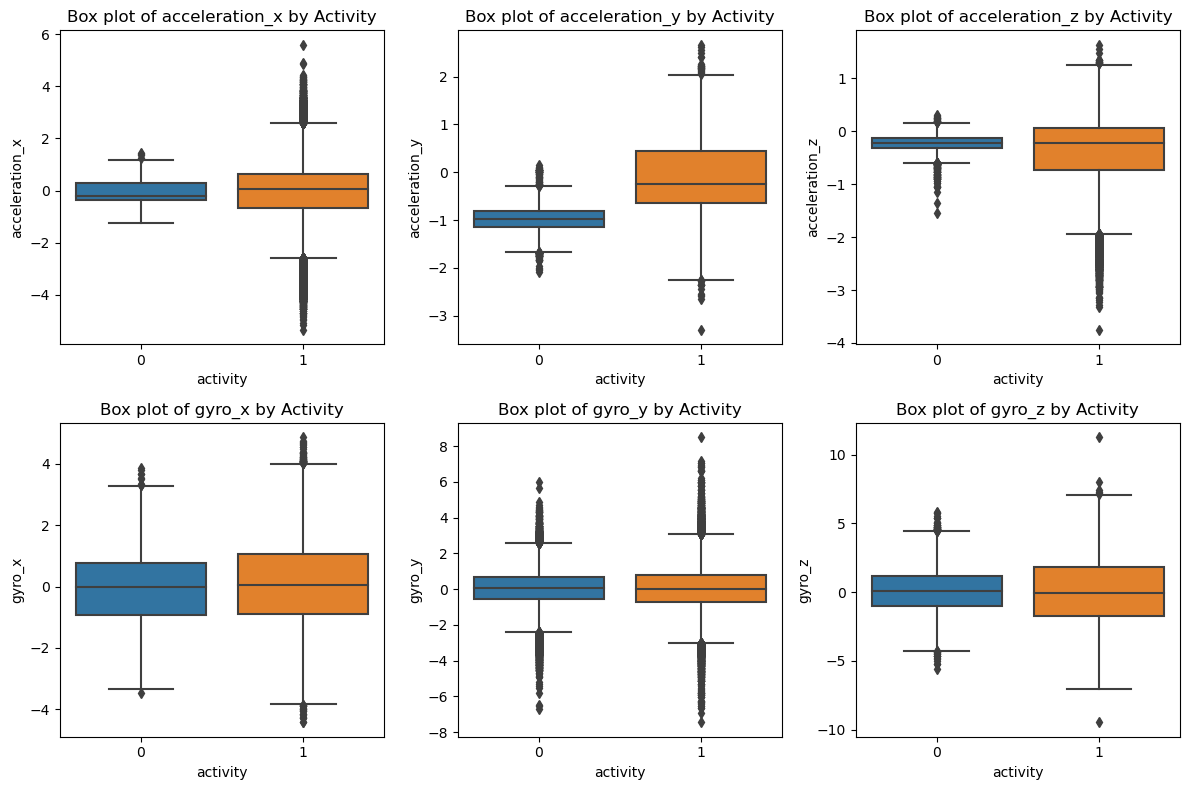

In [14]:
# Select numerical columns for box plots
numerical_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
                  'gyro_x', 'gyro_y', 'gyro_z']

# Create box plots using matplotlib and seaborn
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='activity', y=col, data=df)
    plt.title(f'Box plot of {col} by Activity')

plt.tight_layout()
plt.show()

In [15]:
df

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...,...,...,...,...,...
88583,2017-7-9,20:9:15:317911028,viktor,0,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048
88584,2017-7-9,20:9:15:517889022,viktor,0,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761
88585,2017-7-9,20:9:15:717828989,viktor,0,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616
88586,2017-7-9,20:9:15:917932987,viktor,0,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755


In [16]:
# Calculate Speed
df['Speed'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2 + df['acceleration_z']**2)

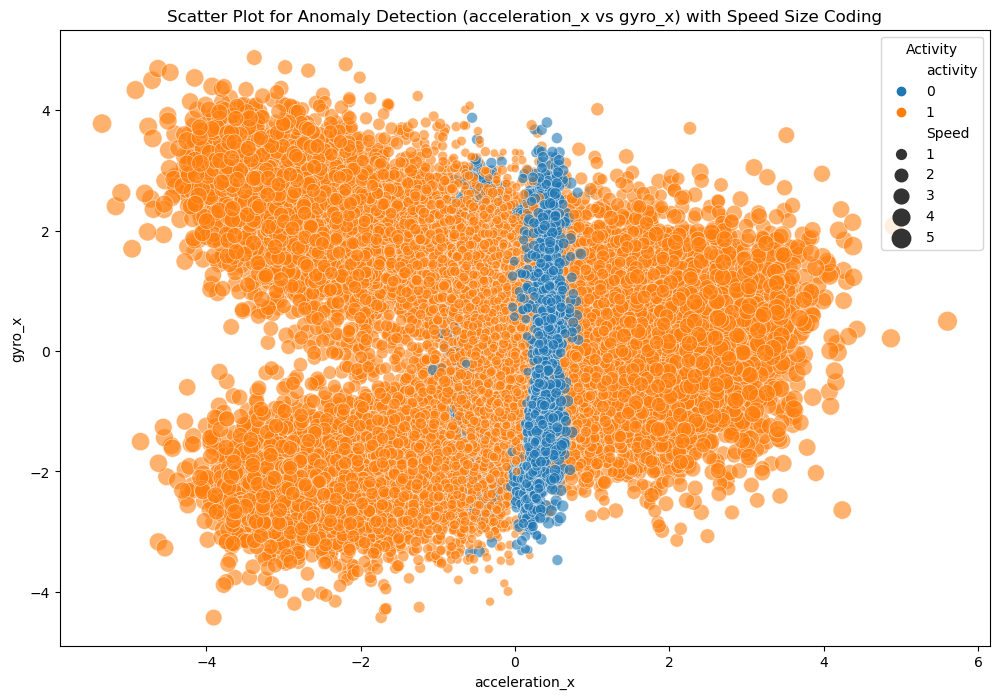

In [17]:
# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='acceleration_x', y='gyro_x', hue='activity', size='Speed', sizes=(20, 200), data=df, alpha=0.6)
plt.title('Scatter Plot for Anomaly Detection (acceleration_x vs gyro_x) with Speed Size Coding')
plt.xlabel('acceleration_x')
plt.ylabel('gyro_x')
plt.legend(title='Activity', loc='upper right')
plt.show()

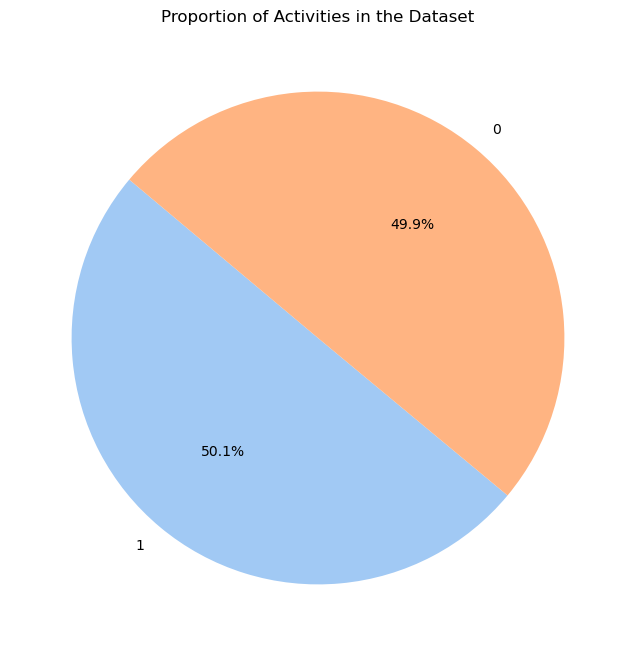

In [18]:
# Count the occurrences of each activity
activity_counts = df['activity'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Proportion of Activities in the Dataset')
plt.show()

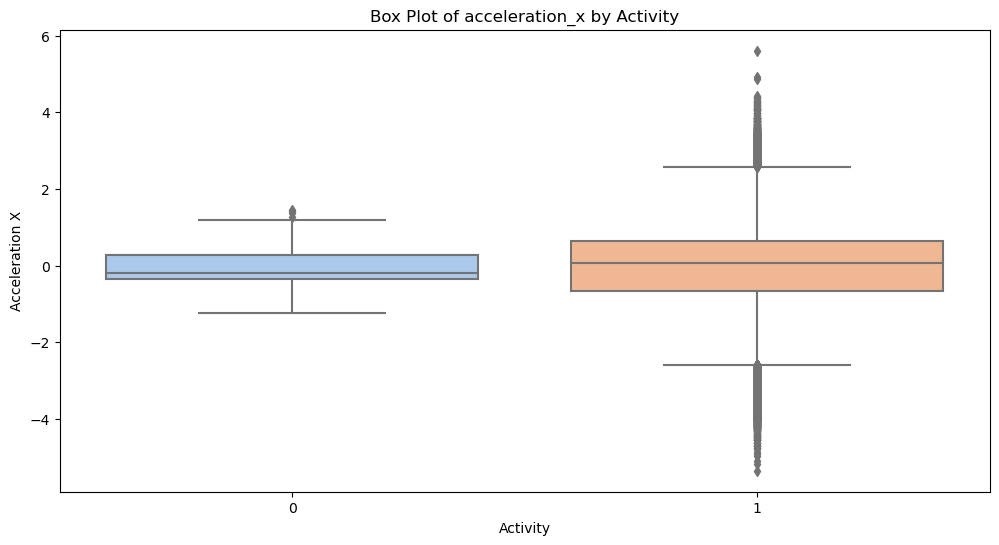

In [19]:
# Convert the activity column to categorical if necessary
df['activity'] = df['activity'].astype('category')

# Create a box plot for the acceleration_x column
plt.figure(figsize=(12, 6))
sns.boxplot(x='activity', y='acceleration_x', data=df, palette='pastel')
plt.title('Box Plot of acceleration_x by Activity')
plt.xlabel('Activity')
plt.ylabel('Acceleration X')
plt.show()


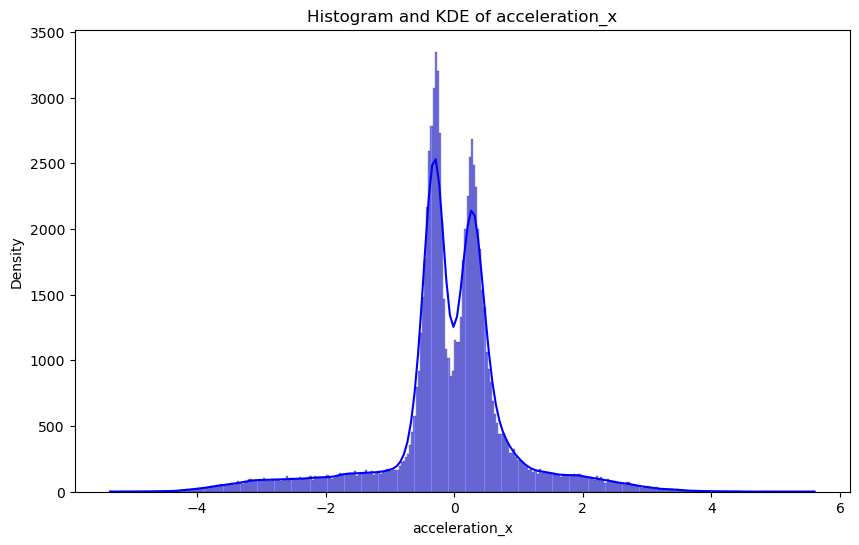

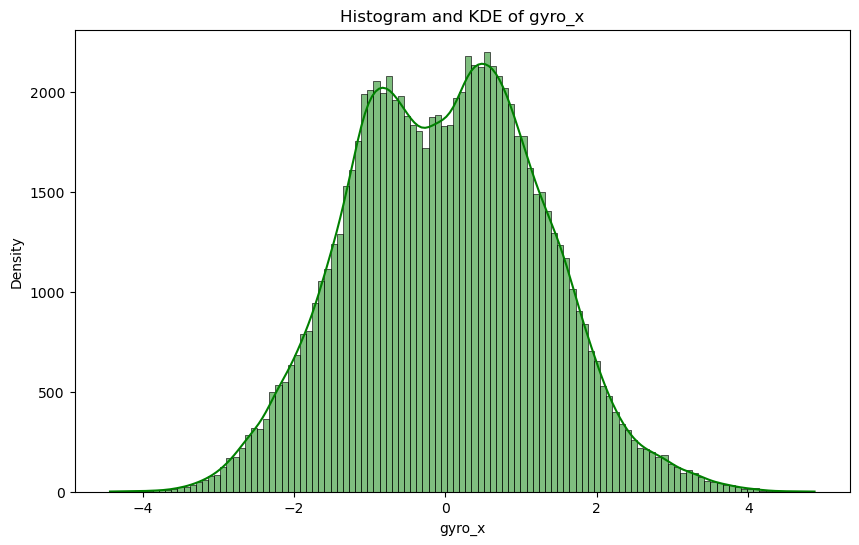

In [20]:
# Histogram for acceleration_x
plt.figure(figsize=(10, 6))
sns.histplot(df['acceleration_x'], kde=True, color='blue')
plt.title('Histogram and KDE of acceleration_x')
plt.xlabel('acceleration_x')
plt.ylabel('Density')
plt.show()

# Histogram for gyro_x
plt.figure(figsize=(10, 6))
sns.histplot(df['gyro_x'], kde=True, color='green')
plt.title('Histogram and KDE of gyro_x')
plt.xlabel('gyro_x')
plt.ylabel('Density')
plt.show()


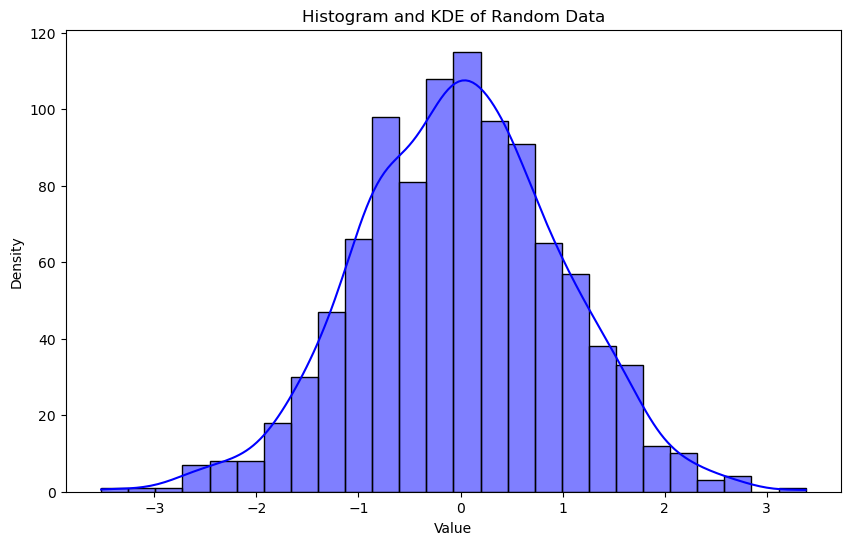

In [21]:
# Generate random data
data = np.random.randn(1000)

# Plot histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color='blue')
plt.title('Histogram and KDE of Random Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

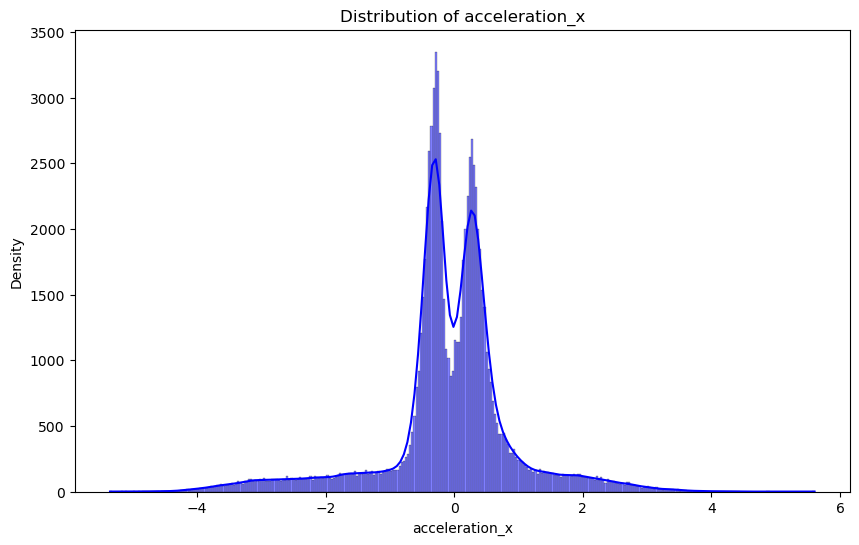

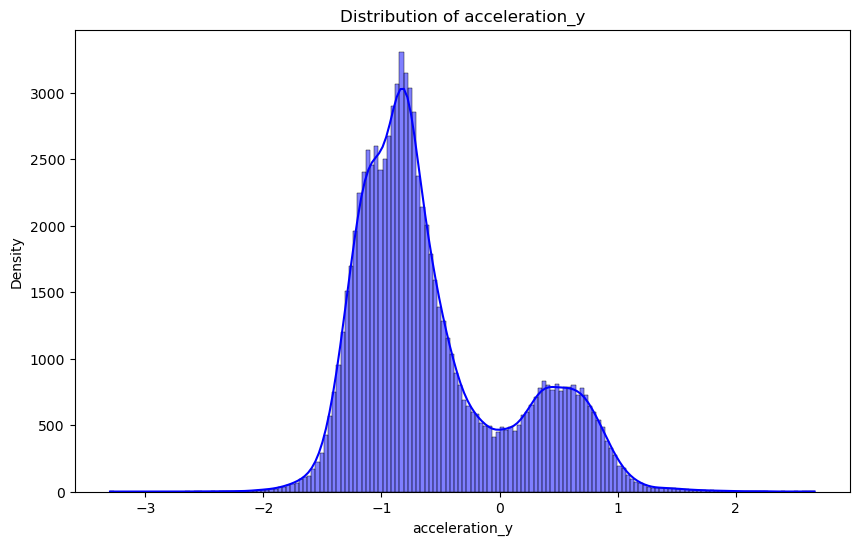

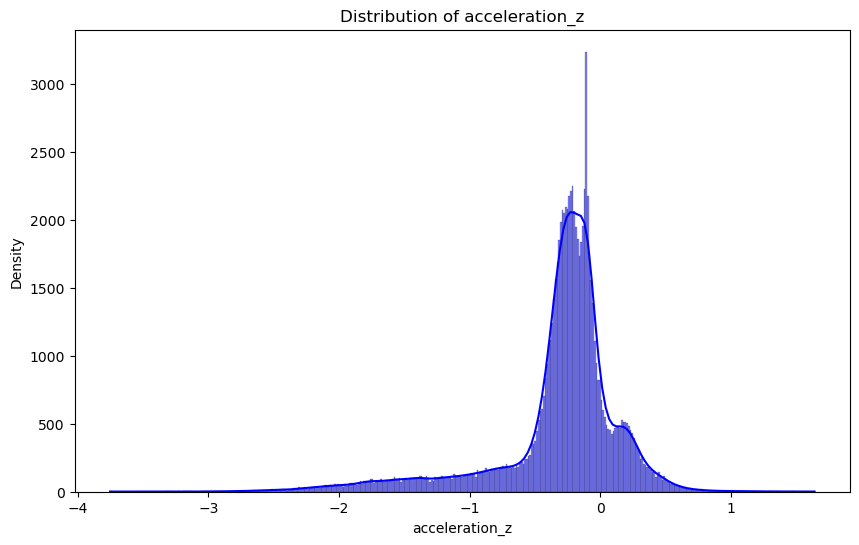

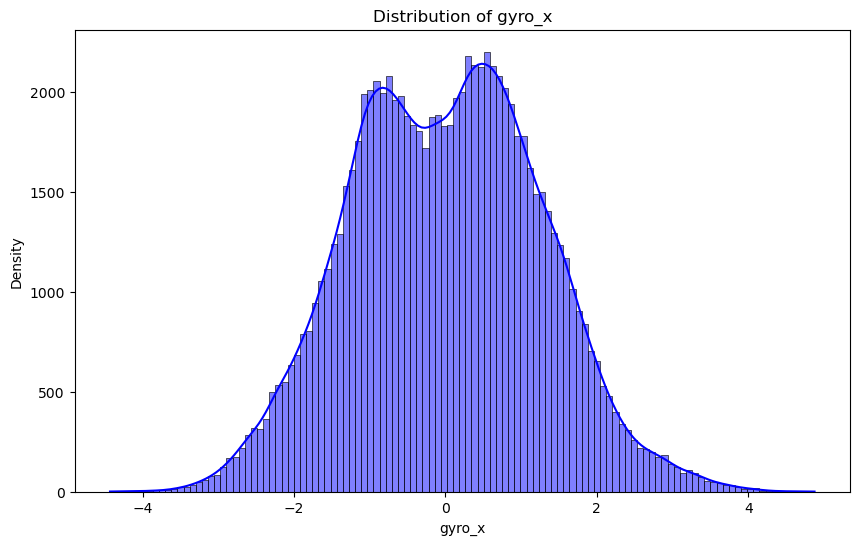

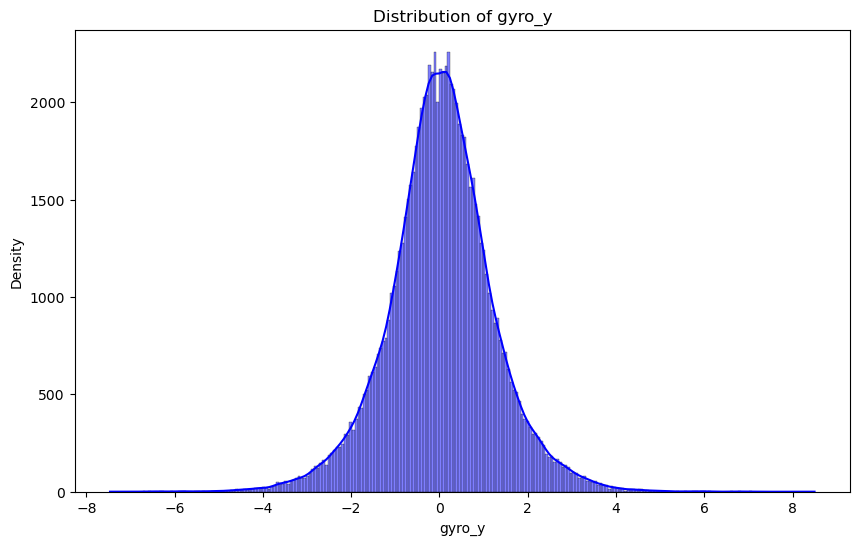

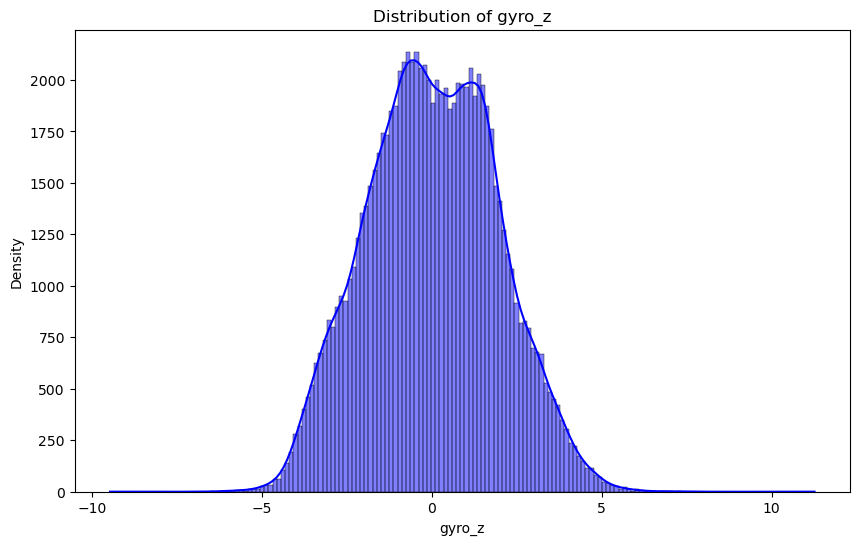

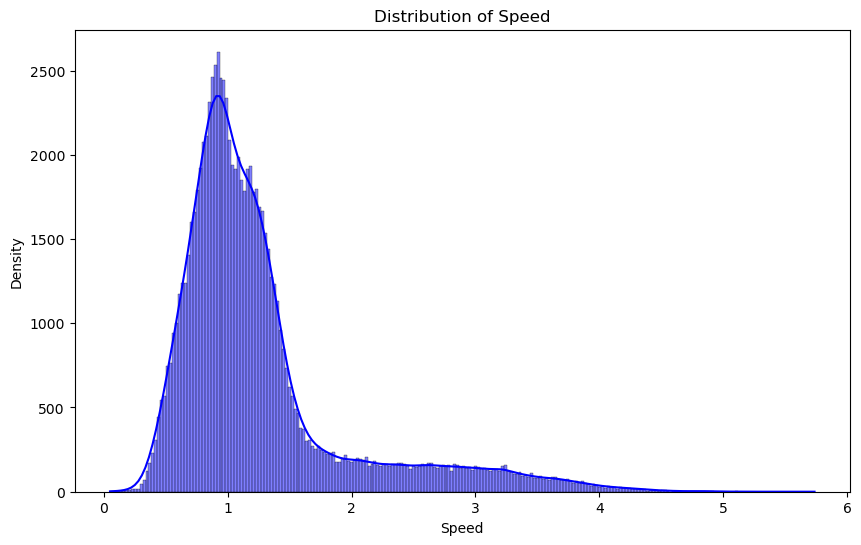

In [22]:
# Select numerical columns (excluding 'wrist', 'date', and 'activity')
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_columns = ['wrist', 'date', 'activity']
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Plot histograms for each numerical column
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

# Feature Engineering

In [23]:
print("Walking activity:", (df['activity'] == 0).sum(axis=0))
print("Running activity:", (df['activity'] == 1).sum(axis=0))

Walking activity: 44223
Running activity: 44365


In [24]:
cols = ['date', 'time']
df['combined'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df2 = df.drop(['username', 'date', 'time', 'wrist'], axis = 1)

In [25]:
#df['datetime'] =  pd.to_datetime(df['time'], format='%d%b%Y:%H:%M:%S.%f')
df2['datetime'] =  pd.to_datetime(df2['combined'], format='%Y-%m-%d %H:%M:%S:%f')
df3 = df2.drop('combined', axis = 1)
df3

,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,Speed,datetime
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,0.825148,2017-06-30 13:51:15.847724020
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269,1.329887,2017-06-30 13:51:16.246945023
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367,1.547307,2017-06-30 13:51:16.446233987
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336,0.871729,2017-06-30 13:51:16.646117985
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922,1.048889,2017-06-30 13:51:16.846738994
...,...,...,...,...,...,...,...,...,...
88583,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048,0.902382,2017-07-09 20:09:15.317911028
88584,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761,1.202684,2017-07-09 20:09:15.517889022
88585,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616,1.295380,2017-07-09 20:09:15.717828989
88586,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755,0.899638,2017-07-09 20:09:15.917932987


In [26]:
df_sorted = df3.sort_values('datetime').reset_index(drop=True)

In [27]:
choice = "2017-07-02"
x_day = df_sorted[df_sorted['datetime'].dt.strftime('%Y-%m-%d') == choice]
print("Total day Samples:", len(x_day))
print("Running samples:", len(x_day.loc[(x_day['activity'] == 1)]))

Total day Samples: 3933
Running samples: 3504


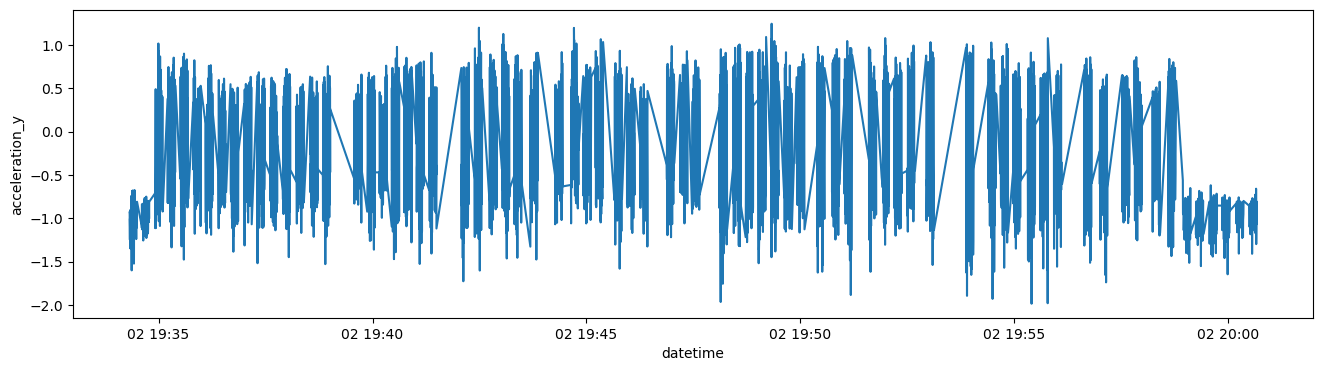

In [28]:
my_figsize = (16, 4)
plt.figure(figsize=my_figsize)

sns.lineplot(x="datetime", y="acceleration_y", data=x_day)
#sns.lineplot(x="datetime", y="acceleration_y", data=df_sorted)

#plt.title('accelerometer')
plt.show()

In [29]:
pd.concat([df_sorted.head(1), df_sorted.tail(1)])

,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,Speed,datetime
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,0.825148,2017-06-30 13:51:15.847724020
88587,1,-2.1825,0.1876,0.0430,-2.2937,-0.6059,-0.6293,2.190970,2017-07-17 20:16:03.851119750


In [30]:
X = df_sorted.iloc[:,1:7]
X

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...
88583,-0.3145,-0.5619,0.2554,-1.4393,0.1370,-1.5961
88584,0.2041,0.4117,-0.1134,0.8280,0.8089,1.9331
88585,-2.9406,0.4090,0.0523,2.2648,0.2342,3.7748
88586,-0.0219,-0.5711,0.1658,0.2210,-1.5538,0.6392


In [31]:
ssc = StandardScaler()
X = ssc.fit_transform(X)
X

array([[ 0.33668266, -0.33231618,  0.6293112 , -0.05039065, -0.00392358,
        -1.5419494 ],
       [ 0.74013342, -0.85156246,  0.16342314, -0.14349622, -0.013684  ,
         0.05462392],
       [ 0.50997229, -1.39586742,  0.79323478, -0.72973418,  0.05764218,
        -1.28448139],
       ...,
       [-2.83940227,  1.47555388,  0.7523566 ,  1.80358291,  0.16433948,
         1.96011707],
       [ 0.05242424, -0.01293187,  0.98550605,  0.17299888, -1.32725368,
         0.32222559],
       [-2.08828236,  1.13931192,  0.73325272, -1.83327848, -0.53649241,
        -0.34037976]])

In [32]:
y = df_sorted.activity
y

0        0
1        0
2        0
3        0
4        0
        ..
88583    1
88584    1
88585    1
88586    1
88587    1
Name: activity, Length: 88588, dtype: category
Categories (2, int64): [0, 1]

In [33]:
# Correlation Analysis
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)

                   wrist  acceleration_x  acceleration_y  acceleration_z  \
wrist           1.000000       -0.609579        0.087091        0.323680   
acceleration_x -0.609579        1.000000       -0.265169       -0.552374   
acceleration_y  0.087091       -0.265169        1.000000        0.106220   
acceleration_z  0.323680       -0.552374        0.106220        1.000000   
gyro_x         -0.022092       -0.021705        0.010549        0.035296   
gyro_y         -0.068403       -0.004091        0.072170       -0.021004   
gyro_z          0.008796       -0.060849       -0.022994        0.049621   
Speed          -0.044768       -0.082358       -0.043168       -0.547627   

                  gyro_x    gyro_y    gyro_z     Speed  
wrist          -0.022092 -0.068403  0.008796 -0.044768  
acceleration_x -0.021705 -0.004091 -0.060849 -0.082358  
acceleration_y  0.010549  0.072170 -0.022994 -0.043168  
acceleration_z  0.035296 -0.021004  0.049621 -0.547627  
gyro_x          1.000000  0.09

# Skewness check

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

In [35]:
# Select numerical columns (excluding 'wrist', 'date', and 'activity')
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_columns = ['wrist', 'date', 'activity','time']
columns_to_analyze = [col for col in numerical_columns if col not in exclude_columns]

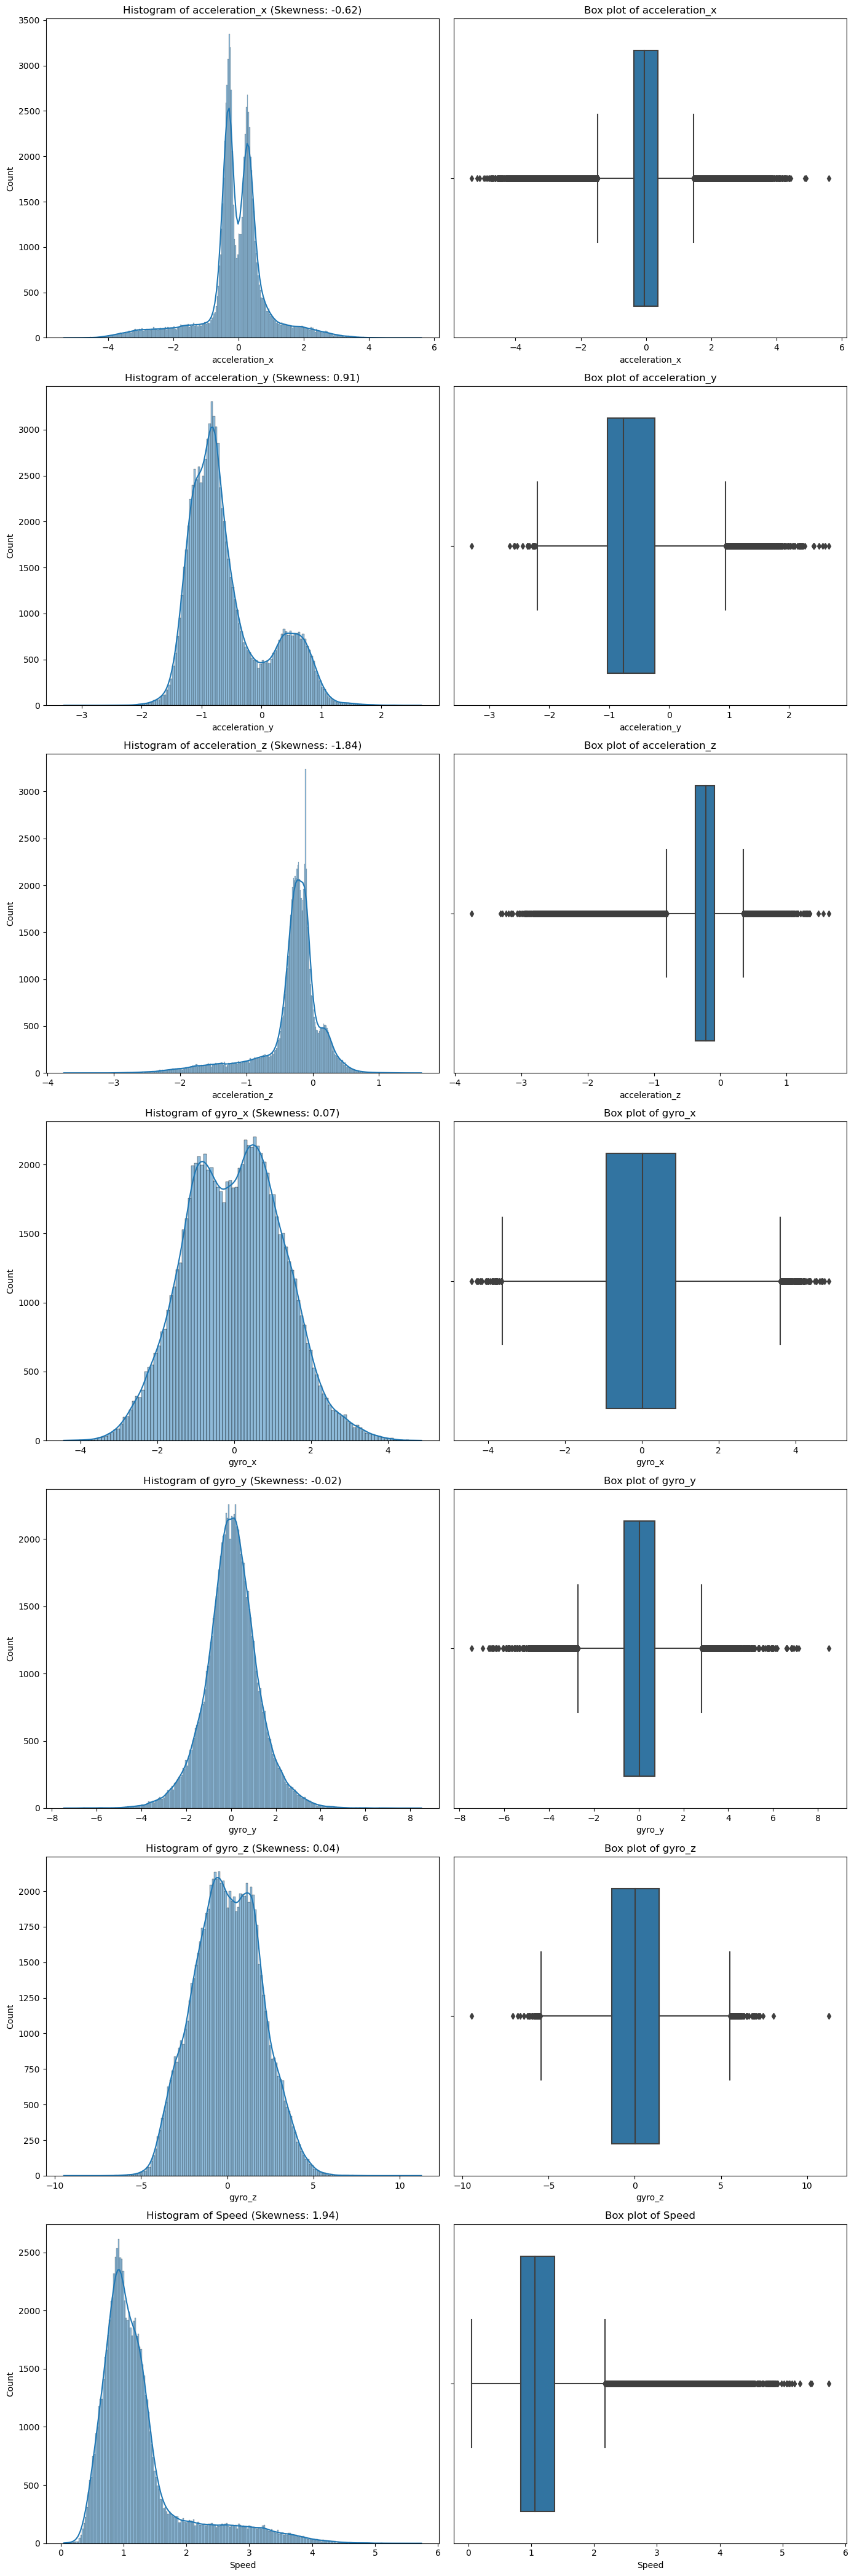

In [36]:
# Calculate skewness for each numerical column
skewness = df[columns_to_analyze].apply(lambda x: skew(x.dropna()))

# Create subplots
fig, axes = plt.subplots(len(columns_to_analyze), 2, figsize=(14, 6 * len(columns_to_analyze)))

# Plot histograms and box plots for each numerical column
for i, column in enumerate(columns_to_analyze):
    # Histogram with KDE
    sns.histplot(df[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column} (Skewness: {skewness[column]:.2f})')
    
    # Box plot
    sns.boxplot(x=df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box plot of {column}')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Outlier detection

Total outliers detected in wrist using Z-Score: 0
Total outliers detected in acceleration_x using Z-Score: 2106
Total outliers detected in acceleration_y using Z-Score: 237
Total outliers detected in acceleration_z using Z-Score: 2293
Total outliers detected in gyro_x using Z-Score: 143
Total outliers detected in gyro_y using Z-Score: 822
Total outliers detected in gyro_z using Z-Score: 80
Total outliers detected in Speed using Z-Score: 2211


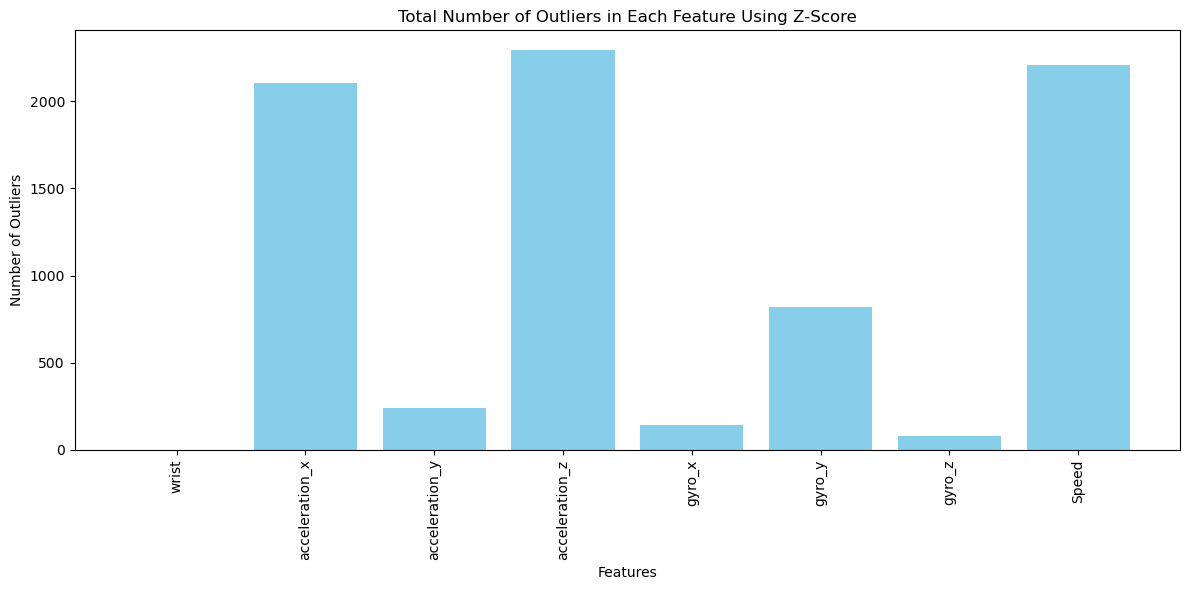

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore



# Select only numeric columns for standardization
numeric_columns = df.select_dtypes(include=[np.number]).columns
standardized_data = df[numeric_columns].apply(zscore)

# Z-Score for outlier detection
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = df[column]
    return df[(z_scores > threshold) | (z_scores < -threshold)]

# Detecting outliers for each feature using Z-Score and counting them
outlier_counts = {}
for column in standardized_data.columns:
    outliers = detect_outliers_zscore(standardized_data, column)
    outlier_counts[column] = len(outliers)
    print(f"Total outliers detected in {column} using Z-Score: {outlier_counts[column]}")

# Plotting the total number of outliers in each column
plt.figure(figsize=(12, 6))
plt.bar(outlier_counts.keys(), outlier_counts.values(), color='skyblue')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.title('Total Number of Outliers in Each Feature Using Z-Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Total outliers detected in wrist using IQR: 0
Total outliers detected in acceleration_x using IQR: 11594
Total outliers detected in acceleration_y using IQR: 1588
Total outliers detected in acceleration_z using IQR: 12637
Total outliers detected in gyro_x using IQR: 225
Total outliers detected in gyro_y using IQR: 3004
Total outliers detected in gyro_z using IQR: 134
Total outliers detected in Speed using IQR: 9761


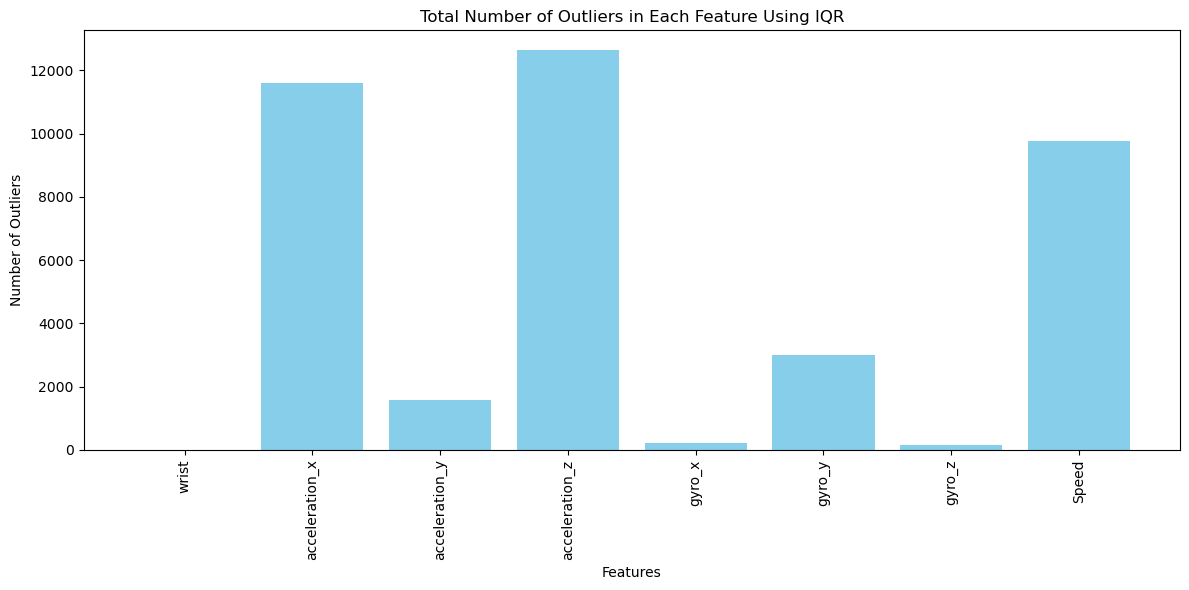

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'standardized_data' is already defined and contains the standardized data

# Interquartile Range (IQR) for outlier detection
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detecting outliers for each feature using IQR and counting them
outlier_counts_iqr = {}
for column in standardized_data.columns:
    outliers = detect_outliers_iqr(standardized_data, column)
    outlier_counts_iqr[column] = len(outliers)
    print(f"Total outliers detected in {column} using IQR: {outlier_counts_iqr[column]}")

# Plotting the total number of outliers in each column
plt.figure(figsize=(12, 6))
plt.bar(outlier_counts_iqr.keys(), outlier_counts_iqr.values(), color='skyblue')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.title('Total Number of Outliers in Each Feature Using IQR')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Test train split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10) 

In [40]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape, y_train.shape

((66441, 6), (66441,))

# Accuracy by Logistic Regression

In [41]:
logr = LogisticRegression()
logr.fit(X_train,y_train)
pred_logr = logr.predict(X_test)

pred_logr

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [42]:
logr_acc = accuracy_score(y_test,pred_logr)
print(logr_acc)

0.8531178037657471


[[9931 1163]
 [2090 8963]]


<Axes: >

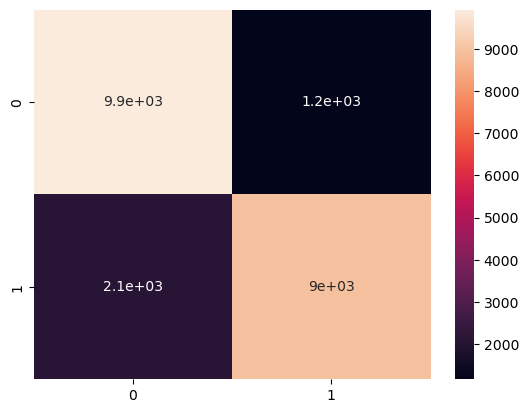

In [43]:
print(confusion_matrix(y_test,pred_logr))
#print(classification_report(y_test,pred_lr))

cm = confusion_matrix(y_test, pred_logr)

sns.heatmap(cm, annot=True)

In [44]:
# Calculate precision, recall, and F1 score for each class
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, pred_logr, average=None)
recall = recall_score(y_test, pred_logr, average=None)
f1 = f1_score(y_test, pred_logr, average=None)

# Print precision, recall, and F1 score for each class
for i, label in enumerate(['Class 0', 'Class 1']):
    print(f"Precision for {label}: {precision[i]:.2f}")
    print(f"Recall for {label}: {recall[i]:.2f}")
    print(f"F1 score for {label}: {f1[i]:.2f}")

# Calculate and print overall precision, recall, and F1 score
overall_precision = precision_score(y_test, pred_logr, average='weighted')
overall_recall = recall_score(y_test, pred_logr, average='weighted')
overall_f1 = f1_score(y_test, pred_logr, average='weighted')

print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 score: {overall_f1:.2f}")

Precision for Class 0: 0.83
Recall for Class 0: 0.90
F1 score for Class 0: 0.86
Precision for Class 1: 0.89
Recall for Class 1: 0.81
F1 score for Class 1: 0.85
Overall Precision: 0.86
Overall Recall: 0.85
Overall F1 score: 0.85


# Accuracy by isolation forest

In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.3, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

# Convert predictions from {1, -1} to {0, 1}
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Print evaluation metrics
print("Accuracy:", accuracy)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Visualization of Anomaly Scores
anomaly_scores = iso_forest.decision_function(X_test)




print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

Accuracy: 0.7332370072696076
Precision: 0.8865514650638617
Recall: 0.5337917307518321
F1-Score: 0.6663654845267676
              precision    recall  f1-score   support

           0       0.67      0.93      0.78     11094
           1       0.89      0.53      0.67     11053

    accuracy                           0.73     22147
   macro avg       0.78      0.73      0.72     22147
weighted avg       0.78      0.73      0.72     22147

[[10339   755]
 [ 5153  5900]]


In [46]:
'''from sklearn.ensemble import IsolationForest

# Instantiate the Isolation Forest estimator
isoforest = IsolationForest(random_state=42)

# Fit the model
isoforest.fit(X_train)

# Predict outliers (-1 for outliers, 1 for inliers)
pred_isoforest = isoforest.predict(X_test)

# Convert predictions (-1 and 1) to binary (0 and 1 where 1 indicates inliers)
pred_isoforest_binary = np.where(pred_isoforest == 1, 0, 1)

# Accuracy score (for anomaly detection, we typically use metrics like precision, recall, or F1-score)
# In this case, we could calculate accuracy as the percentage of correctly identified inliers
isoforest_acc = accuracy_score(y_test, pred_isoforest_binary)
print("Accuracy for Isolation Forest: {:.2f}".format(isoforest_acc))'''


'from sklearn.ensemble import IsolationForest\n\n# Instantiate the Isolation Forest estimator\nisoforest = IsolationForest(random_state=42)\n\n# Fit the model\nisoforest.fit(X_train)\n\n# Predict outliers (-1 for outliers, 1 for inliers)\npred_isoforest = isoforest.predict(X_test)\n\n# Convert predictions (-1 and 1) to binary (0 and 1 where 1 indicates inliers)\npred_isoforest_binary = np.where(pred_isoforest == 1, 0, 1)\n\n# Accuracy score (for anomaly detection, we typically use metrics like precision, recall, or F1-score)\n# In this case, we could calculate accuracy as the percentage of correctly identified inliers\nisoforest_acc = accuracy_score(y_test, pred_isoforest_binary)\nprint("Accuracy for Isolation Forest: {:.2f}".format(isoforest_acc))'

# Accuracy by KNN

In [47]:
# instantiate the estimator
knn = KNeighborsClassifier()

# fit the model
knn.fit(X_train, y_train)

# predict the response
pred_knn = knn.predict(X_test)

# accuracy score
knn_acc = accuracy_score(y_test, pred_knn)
print ("Accuracy for KNN: {}".format(knn_acc))

Accuracy for KNN: 0.9888472479342575


In [48]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train[0:1000], y_train[0:1000])
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))


Text(0, 0.5, 'Mean Error')

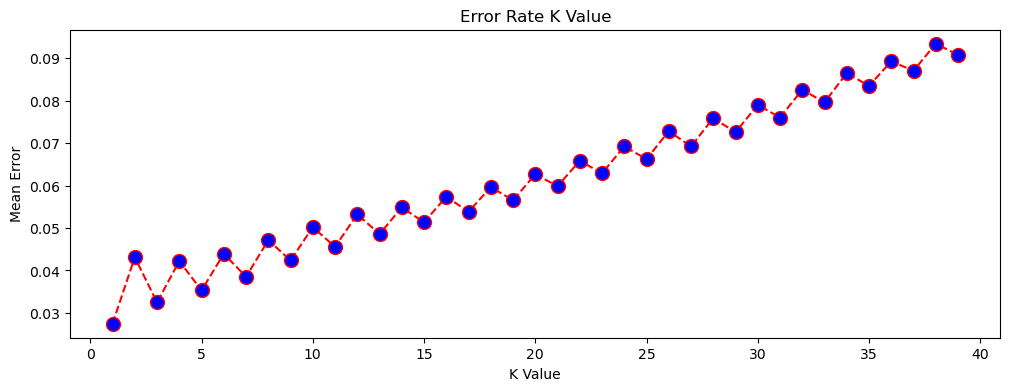

In [49]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Accuracy by SVM

In [50]:
# instantiate the estimator
svm = SVC()

# fit the model
svm.fit(X_train, y_train)

# predict the response
pred_svm = svm.predict(X_test)

# accuracy score
svm_acc = accuracy_score(y_test, pred_svm)
print ("Accuracy for SVM: {}".format(svm_acc))

Accuracy for SVM: 0.9870411342394003


# Accuracy by Naive Bayes

In [51]:
# instantiate the estimator
nb = GaussianNB()

# fit the model
nb.fit(X_train, y_train)

# predict the response
pred_nb = nb.predict(X_test)

# accuracy score
nb_acc = accuracy_score(y_test, pred_nb)
print ("Accuracy for Gaussian Naive Bayes: {}".format(nb_acc))

Accuracy for Gaussian Naive Bayes: 0.9581433151216869


# Accuracy by CNN model

In [52]:
model = Sequential()
model.add(Dense(250, activation = 'relu', input_shape = (6,)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 250)                 │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250)                 │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001 (11.72 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 500 (1.95 KB)

In [53]:
model.compile(loss = 'binary_crossentropy', optimizer = 'ADAM', metrics = ['accuracy'])

In [54]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint with filepath ending in '.keras'
checkpoint = ModelCheckpoint("walk_run.keras", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

# Define EarlyStopping
early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=7, 
                      verbose=1, 
                      mode='auto')


In [55]:
history = model.fit(X_train, y_train, 
          batch_size = 1000, 
          epochs = 50, 
          validation_split = 0.2,
          callbacks=[checkpoint,early],
          verbose = 2)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.61660, saving model to walk_run.keras
54/54 - 4s - 78ms/step - accuracy: 0.8887 - loss: 0.2668 - val_accuracy: 0.6166 - val_loss: 0.5063
Epoch 2/50

Epoch 2: val_accuracy improved from 0.61660 to 0.66115, saving model to walk_run.keras
54/54 - 1s - 12ms/step - accuracy: 0.9677 - loss: 0.1020 - val_accuracy: 0.6611 - val_loss: 0.4575
Epoch 3/50

Epoch 3: val_accuracy improved from 0.66115 to 0.74731, saving model to walk_run.keras
54/54 - 1s - 11ms/step - accuracy: 0.9745 - loss: 0.0785 - val_accuracy: 0.7473 - val_loss: 0.3984
Epoch 4/50

Epoch 4: val_accuracy improved from 0.74731 to 0.86342, saving model to walk_run.keras
54/54 - 1s - 12ms/step - accuracy: 0.9783 - loss: 0.0678 - val_accuracy: 0.8634 - val_loss: 0.3113
Epoch 5/50

Epoch 5: val_accuracy improved from 0.86342 to 0.93920, saving model to walk_run.keras
54/54 - 1s - 11ms/step - accuracy: 0.9801 - loss: 0.0616 - val_accuracy: 0.9392 - val_loss: 0.2251
Epoch 6/50

E

In [56]:
print("Evaluate model on test data")

# Ensure X_test and y_test are numpy arrays and have compatible shapes
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the model
results = model.evaluate(X_test, y_test, batch_size=1000)

# Print the results
print("Test loss, test accuracy:", results)

# Generate a prediction using model.predict() 
# and calculate its shape
print("Generate a prediction")

# Example prediction for the first sample in X_test
prediction = model.predict(X_test[:1])

print("Prediction shape:", prediction.shape)


Evaluate model on test data
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0338
Test loss, test accuracy: [0.0340791754424572, 0.9883956909179688]
Generate a prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediction shape: (1, 1)


In [57]:
best_model_acc = history.history['accuracy'][np.argmin(history.history['loss'])]
cnn_acc = best_model_acc

print ("Accuracy for CNN: {}".format(cnn_acc))

Accuracy for CNN: 0.9881095886230469


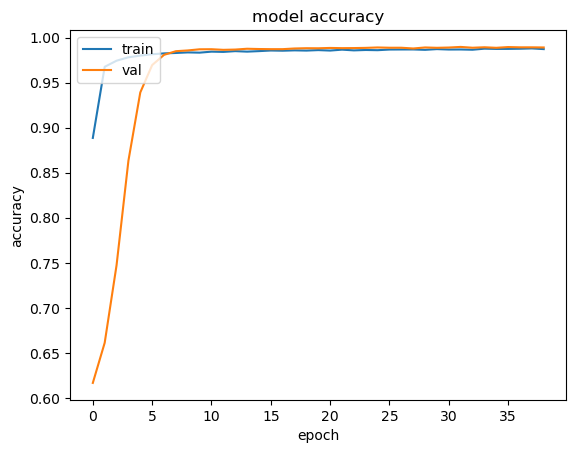

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

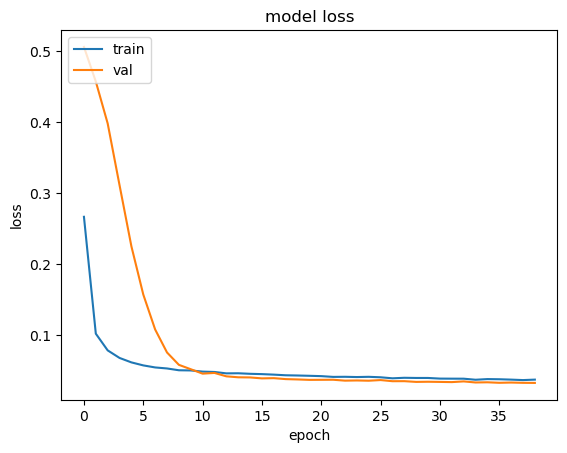

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, np.rint(y_pred))
cm

693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[11023,    71],
       [  186, 10867]], dtype=int64)

In [61]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11023    71]
 [  186 10867]]


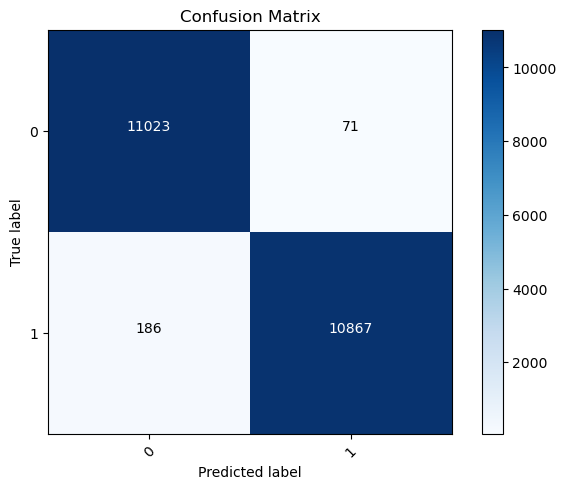

In [62]:
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [65]:
models = pd.DataFrame([logr_acc,accuracy,svm_acc,knn_acc,nb_acc,cnn_acc],
             index=['Logistic Regression','Isolation forest','SVM','KNN','Naive Bayes','CNN'],columns=['accuracy'])

models.sort_values('accuracy', ascending=False)

,accuracy
KNN,0.988847
CNN,0.988110
SVM,0.987041
Naive Bayes,0.958143
Logistic Regression,0.853118
Isolation forest,0.733237


In [66]:
models.accuracy.sort_values(ascending=False).values

array([0.98884725, 0.98810959, 0.98704113, 0.95814332, 0.8531178 ,
       0.73323701])

<Axes: >

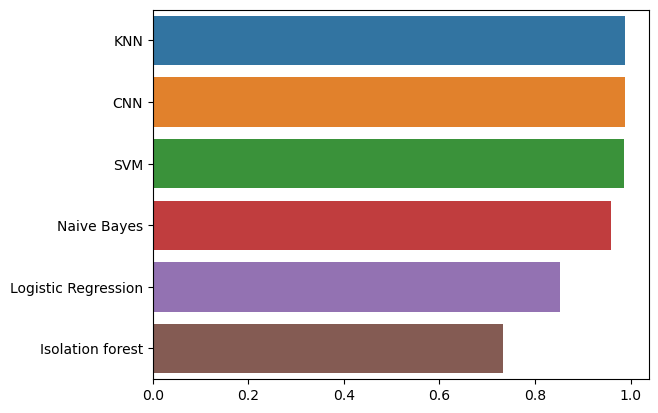

In [67]:
sns.barplot(x = models.accuracy.sort_values(ascending=False).values, 
            y = models.accuracy.sort_values(ascending=False).index)